# ***1. REFERENCES & IMPORT LIBRARY***

In [1]:
!pip install torchsummary
!pip install torchgeometry
!pip install torchmetrics

In [2]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb
import torchmetrics

# ***2. DATA VÀ DATALOADER***

## 2.1 Làm quen với data, thử in train và train_gt dataset

1 ảnh gốc
(995, 1280, 3) High: 995 Width: 1280 Chanel: 3


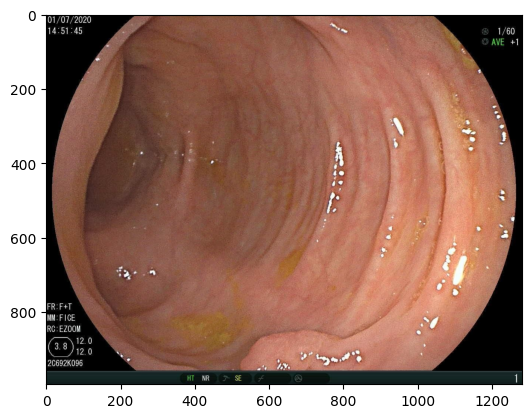

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = "/kaggle/input/bkai-igh-neopolyp/train/train/0081835cf877e004e8bfb905b78a9139.jpeg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # cv2 đọc BGR
plt.imshow(image)     # PIL và plt đọc RGB
print("1 ảnh gốc")
print(image.shape, "High:", image.shape[0], "Width:", image.shape[1], "Chanel:", image.shape[2])



Ảnh mặt nạ mask
(995, 1280, 3) High: 995 Width: 1280 Chanel: 3


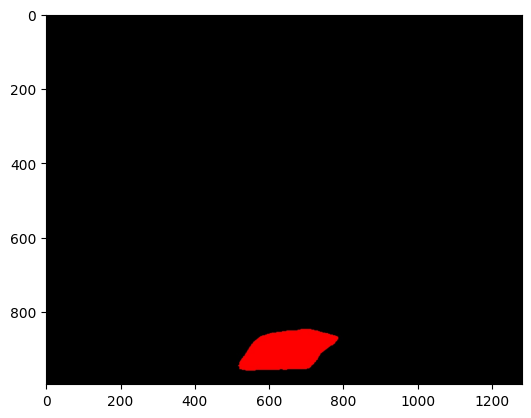

In [4]:

mask_path = "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg"
mask = cv2.imread(mask_path)    # mặt nạ
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)     
print("Ảnh mặt nạ mask")
print(mask.shape, "High:", mask.shape[0], "Width:", mask.shape[1], "Chanel:", mask.shape[2])

## 2.2 DataLoader: Transform và class Neopolyp_DataClass

### 2.2.1 Transform:    
- https://app.roboflow.com/ sinh ảnh hoặc tự code (đã từng). Có hơn 10 loại aug. 
- Lib: Update transform thêm Augmentation: https://albumentations.ai/docs/getting_started/mask_augmentation/
Nhiều hơn: https://albumentations.ai/docs/api_reference/full_reference/

In [5]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from PIL import Image
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# transform cơ bản, lát có transform update augmentation 
height, width = 800, 1120
basic_transform = Compose([Resize((height, width), interpolation=InterpolationMode.BILINEAR),   # height = 800, width = 1120, kích thước ảnh tất cả ảnh phải cùng nhau và cùng là bội của 32
                     PILToTensor()])   
# phương pháp nội suy song tuyến (bilinear interpolation), 
# - `InterpolationMode.BILINEAR` `torchvision` PyTorch, dạng tensor PyTorch.
#- `cv2.INTER_LINEAR`  `cv2` (OpenCV), mảng numpy hoặc raw.

# Update transform thêm Augmentation: https://albumentations.ai/docs/getting_started/mask_augmentation/
# Nhiều hơn: https://albumentations.ai/docs/api_reference/full_reference/
train_transform = A.Compose(
    [
    A.Resize(256, 256, interpolation=cv2.INTER_LINEAR),       # kiểu numpy array, 
    A.VerticalFlip(),
    A.HorizontalFlip(),  #  mặc định p=0.5
        
    A.OneOf([
    A.Blur(blur_limit=3, p=0.3),   # làm mờ, độ mờ ngẫu nhiên từ 0-3
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.MedianBlur(blur_limit=3, p=0.3),
    A.RandomBrightnessContrast()  # độ tương phản hình ảnh, mặc định p=0.2
    ], p=0.3),
        
    A.Rotate(limit=30, p=0.3),
        
    A.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5), 
    # ngẫu nhiên dịch chuyển kênh màu từ 0-20
    A.Cutout (num_holes=5, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False),    # mặc định p=0.5
    # cắt đi 1 khoảng model vẫn học được    
    A.GaussNoise(p=0.3),
        
    A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # Mean and std of ImageNet (tập data rất lớn) là như trên phổ biến cho các model, 
    ToTensorV2(), 
]
)

# Compose là 1 lần đi qua các ảnh gốc này, mỗi phép biến đổi xuất hiện với xác suất p 

# val ko cần thêm nhiễu gì cả, chỉ cần resize và normalize 
val_transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_LINEAR),
    A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # Mean and std of ImageNet (tập data rất lớn) là như trên phổ biến cho các model, 
    ToTensorV2(),
])



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


### 2.2.2 DataLoader:   
- https://pytorch.org/docs/stable/data.html
- Dataset trong Pytorch có Map-style datasets (thường dùng) và Iterable-style datasets
- DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)
           
    - DataLoader: tự động tạo các batch từ Dataset, cung cấp xáo trộn data và tải song song. 

In [6]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class NeolypsDataset(Dataset):
    """
    Dataset class cho việc huấn luyện và kiểm tra mô hình trên bộ dữ liệu Neolyps.
    Attributes:
        img_list (list): Danh sách đường dẫn tới các hình ảnh.
        mask_list (list): Danh sách đường dẫn tới các mask ứng với hình ảnh.
        transform (callable, optional): Transform function áp dụng lên ảnh và mask.
    """

    def __init__(self, img_list, mask_list, transform=None):
        """
        Khởi tạo dataset với danh sách hình ảnh và mask.
        Parameters:
            img_list (list): Danh sách đường dẫn hình ảnh.
            mask_list (list): Danh sách đường dẫn mask.
            transform (callable, optional): Hàm biến đổi áp dụng lên dữ liệu.
        """
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform

        print(f'Số lượng hình ảnh: {len(self.img_list)}')
        print(f'Số lượng mask: {len(self.mask_list)}')

    def __len__(self):
        """
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.img_list)

    def _read_mask(self, mask_path):
        """
        Đọc và xử lý mask từ đường dẫn đã cho.
        Parameters:
            mask_path (str): Đường dẫn đến mask.
        Returns:
            np.array: Mask đã được xử lý.
        """
        # Đọc và chuyển đổi sang không gian màu HSV
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

        # Định nghĩa các ngưỡng màu cho red và green
        # Red: Màu đỏ
        lower1, upper1 = np.array([0, 100, 20]), np.array([10, 255, 255])
        lower2, upper2 = np.array([160, 100, 20]), np.array([179, 255, 255])
        # Green: Màu xanh lá
        lower_g, upper_g = np.array([35, 25, 25]), np.array([70, 255, 255])

        # Tạo mask cho màu đỏ và xanh lá
        red_mask = cv2.inRange(mask, lower1, upper1) + cv2.inRange(mask, lower2, upper2)
        green_mask = cv2.inRange(mask, lower_g, upper_g)

        # Đánh dấu các pixel tương ứng
        red_mask[red_mask != 0] = 1   # Neopolyp pixel = 1
        green_mask[green_mask != 0] = 2 # Non-neopolyp pixel = 2, background = 0

        # Kết hợp mask
        full_mask = cv2.bitwise_or(red_mask, green_mask).astype(np.int8)

        return full_mask

    def __getitem__(self, idx):
        """
        Lấy một mẫu dữ liệu từ dataset.
        Parameters:
            idx (int): Index của mẫu dữ liệu.
        Returns:
            tuple: Bao gồm ảnh và mask tương ứng đã được biến đổi.
        """
        # Đọc hình ảnh và mask
        img_path, mask_path = self.img_list[idx], self.mask_list[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = self._read_mask(mask_path)

        # Áp dụng transform nếu có
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed['image'].float(), transformed['mask'].float()

        return img, mask


1000 1000
Số lượng hình ảnh: 900
Số lượng mask: 900
Số lượng hình ảnh: 100
Số lượng mask: 100
torch.Size([3, 256, 256]) torch.float32 torch.Size([256, 256]) torch.float32


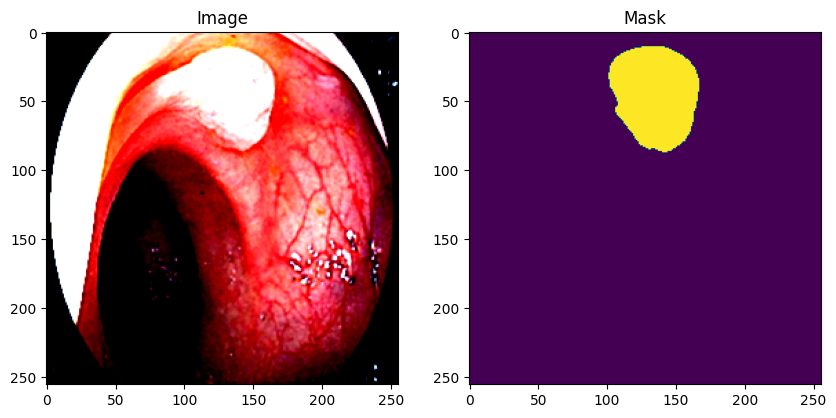

In [7]:
# load hết địa chỉ vào 1 list
img_dir = '/kaggle/input/bkai-igh-neopolyp/train/train'
mask_dir = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
img_list = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
mask_list = [os.path.join(mask_dir, x) for x in os.listdir(mask_dir)]
print(len(img_list), len(mask_list))
# print(img_list)  # load hết địa chỉ vào 1 list

# Tạo Train, Val Dataset với train_transform, val_transform - chưa Dataloader
train_size = int(0.9 * len(img_list))
train_dataset = NeolypsDataset(img_list[:train_size], mask_list[:train_size], transform=train_transform)
val_dataset = NeolypsDataset(img_list[train_size:], mask_list[train_size:], transform=val_transform)

# get a sample image and mask from the dataset, # plot the image and mask
import matplotlib.pyplot as plt
img, mask = train_dataset[0]
print(img.shape, img.dtype, mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.show()

In [8]:
# Tạo Dataloader
batch_size = 4  # kích thước mỗi batch trong train-test, 
# số mẫu data được đưa vào model mỗi lần cập nhật trọng số
# batch_size càng lớn thì càng nhanh nhưng cũng càng tốn bộ nhớ

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of samples in train_dataloader: {len(train_dataloader.dataset)}")
print(f"Batch size of train_dataloader: {train_dataloader.batch_size}")


Number of batches in train_dataloader: 225
Number of samples in train_dataloader: 900
Batch size of train_dataloader: 4


In [9]:
# Code for UnNormalize - nếu muốn xem ảnh gốc: 
class UnNormalize(object): 
    def __init__(self, mean, std): 
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor): 
        for t, m, s in zip(tensor, self.mean, self.std): 
            t.mul_(s).add_(m)  # Sử dụng add_ thay vì add để thực hiện phép tính trực tiếp trên tensor
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


# ***3. MODEL***
Lib: https://github.com/qubvel/segmentation_models.pytorch#architectures
`!pip install segmentation-models-pytorch`. Train tiếp model đã được train (thiết lập tham số config)

In [10]:
!pip install segmentation-models-pytorch

In [11]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet152",       # Chọn ResNet-101 làm backbone
    encoder_weights="imagenet",    # Sử dụng trọng số được huấn luyện trên ImageNet
    in_channels=3,                 # Số kênh đầu vào, = 3 cho ảnh RGB
    classes=3                      # Số lớp đầu ra = 3, đỏ xanh background
)
# print(model)
# import torchsummary
# torchsummary.summary(model,(3,256,256))

# Kích thước sau Augmentation: 
# img: torch.Size([3, 256, 256]) torch.float32
# mask: torch.Size([256, 256]) torch.float32

# Training

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [12]:
torch.cuda.empty_cache()


In [13]:
batch_size = 4   # thiết lập trên dataloader rồi

#thiết lập cpu/gpu luôn
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = model.to(device)  

# Hàm loss
criterion = nn.CrossEntropyLoss()   # # Hàm tính loss là Cross Entropy Loss

# Hàm lr
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)  # Sử dụng optimizer Adam

# Khởi tạo các metrics để đo lường
dice_fn = torchmetrics.Dice(num_classes=3, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=3, task="multiclass", average="macro").to(device)

# 
num_epochs = 25
best_val_loss = 9999999
display_step = 50

def accuracy_function(preds, labels):
    # Hàm tính accuracy
    return torch.sum(preds == labels).float() / labels.numel()


In [14]:
import wandb
wandb.login(key = "c8767797aae76cbcd389ff29929ace1ac3021161")    # key's DoanNgocCuong
wandb.init(
    project = "PolypSegment"
)

wandb: Currently logged in as: doanngoccuong (doanngoccuong_nh). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output) 

In [19]:
from tqdm import tqdm   # not import tqdm

#thiết lập cpu/gpu lại
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = model.to(device)  

num_epochs = 200  # Số lượng epochs

# Training loop
# Initialize best validation loss for tracking improvement
best_val_loss = float('inf')

for epoch in range(0, num_epochs):   # nhớ lát epoch+1
    model.train()  # Chuyển model sang trạng thái training
    train_loss, train_dice, train_iou, train_accuracy = 0, 0, 0, 0 

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)  # Chuyển dữ liệu sang thiết bị (GPU/CPU)
        labels = labels.long()  # Chuyển nhãn sang kiểu dữ liệu Long, thích hợp cho nn.CrossEntropyLoss.
                                
        optimizer.zero_grad()  # Xóa gradient cũ
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, labels)  # Tính loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Cập nhật trọng số model

        train_loss += loss.item()  # Cộng dồn loss

        # Tính toán các chỉ số khác
        preds = torch.argmax(outputs, dim=1)    # preds chỉ mục lớp dự đoán, và labels nhãn ground truth
        train_dice += dice_fn(preds, labels).item()
        train_iou += iou_fn(preds, labels).item()
        train_accuracy += accuracy_function(preds, labels).item()

    # Tính trung bình cho mỗi chỉ số loss, dice, iou, acc 
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_dice = train_dice / len(train_dataloader)
    avg_train_iou = train_iou / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)

    # Sau mỗi vòng for (mỗi epoch) Log các chỉ số vào wandb và print ra console
    wandb.log({
        "Train Loss": avg_train_loss,
        "Train Dice": avg_train_dice,
        "Train IoU": avg_train_iou,
        "Train Accuracy": avg_train_accuracy,
        "Epoch": epoch+1
    })
    # Nhớ cộng 1, ko là bug: epoch từ 0, 1, 2...
    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Train Dice: {avg_train_dice}, "
          f"Train IoU: {avg_train_iou}, Train Accuracy: {avg_train_accuracy}")
    
    # Validation loop sau mỗi epoch train, tt training loop nhưng không cần backward và step
    model.eval()  # Chuyển model sang trạng thái đánh giá
    val_loss = 0
    with torch.no_grad():  # Không tính toán gradient
        for imgs, labels in val_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.long()  # Convert labels to long type <-- Add this line
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()

    # Tính trung bình loss trên tập validation, print ra console và lưu vào wandb
    avg_val_loss = val_loss / len(val_dataloader)
    wandb.log({"Avg Validation Loss": avg_val_loss, "Epoch": epoch+1}) 
    print("at Epoch", epoch+1, "Avg Validation Loss", avg_val_loss )

    # Thêm 1 lastest_checkpoint để dễ train tiếp hơn
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epoch': epoch+1
    }
    torch.save(checkpoint, 'lastest_model.pth')  # Lưu trạng thái mô hình và thông tin liên quan
    
    
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         torch.save(model.state_dict(), 'best_model.pth')  # Lưu model tốt nhất
#         wandb.log({"Best Validation Loss": best_val_loss})
    
    # Ko chỉ lưu model tốt nhất, lưu thêm cả optimizer, best_val_loss, epoch để train tiếp backup
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss     # update best model
        
        # Lưu trạng thái best_model checkpoint 
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch': epoch+1
        }
        
        # lưu best_model.pth vào thư mục hiện tại và wandb với arifact
#         torch.save(checkpoint, 'best_model.pth')        
        model_checkpoint_path = f'best_model_epoch_{epoch+1}.pth'
        torch.save(checkpoint, model_checkpoint_path)
        
        # log artifact với wandb - lưu model  (ko có đoạn này thì chỉ log thông tin chỉ số, ko log model)
        artifact = wandb.Artifact(name='model_checkpoint', type='model', description='Best model checkpoint')
        artifact.add_file(model_checkpoint_path)
        wandb.log_artifact(artifact)
        
        # Log và print các chỉ số Validation - epoch
        wandb.log({"Best Validation Loss": best_val_loss, "Epoch": epoch+1})
        print("Now Best Validation Loss, at epoch", epoch+1, " best_val_loss is", best_val_loss)

    if epoch%5==0:  # Dự đoán Resnet152-100 epoch, resnet34-300 epochs (loss:0.1), Resnet101-200 epochs
        label = labels[0].cpu().numpy()
        label = mask_to_rgb(label,color_dict)
        outputs[0] = outputs[0].softmax(dim=0)
        output = outputs[0].cpu().numpy()
        output = np.argmax(output, axis=0)
        output = mask_to_rgb(output,color_dict)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(label)
        axs[0].set_title('Label')
        axs[1].imshow(output)
        axs[1].set_title('Output')
        plt.show()



Epoch 1/200:  18%|█▊        | 41/225 [00:23<01:45,  1.74it/s]


KeyboardInterrupt: 

In [36]:
# Tải lại thông tin model đã train
checkpoint = torch.load('/kaggle/working/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_val_loss = checkpoint['best_val_loss']
epoch = checkpoint['epoch']

print("Now, best model at", "epoch", epoch, " best_val_loss is", best_val_loss, "and Optimizer is", optimizer)
    

# Tải lại thông tin model đã train
checkpoint = torch.load('/kaggle/working/lastest_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_val_loss = checkpoint['best_val_loss']
epoch = checkpoint['epoch']

print("Now, lastest model at", "epoch", epoch, " best_val_loss is", best_val_loss, "and Optimizer is", optimizer)
    

Now, best model at epoch 23  best_val_loss is 0.04574570441618562 and Optimizer is Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


RuntimeError: PytorchStreamReader failed locating file data/3: file not found

Up được: 0.62 score

## 4.2 Train tiếp model mình vừa train (). 
- Thông qua lastest_model.pth, best_model.pth trên thư mục hiện tại. 
- Hoặc qua wandb - artifact (cần có code log lên wandb chứ ban đầu chỉ log chỉ số metrics, ...)
- Chú ý: 
1. Chú ý: load best_val_loss vì best_val_loss đang là của thằng best_model
```python
checkpoint = torch.load('/kaggle/working/best_model.pth')
best_val_loss = checkpoint['best_val_loss']
```

2. Thay range(epochs) thành range(epoch, epochs) 


1. 30 epochs đầu
- Epoch 7/30: 100%|██████████| 225/225 [01:52<00:00,  2.00it/s]
Epoch: 7, Train Loss: 0.06242561957074536, Train Dice: 0.6765225545565288, Train IoU: 0.6220268830988143, Train Accuracy: 0.9822562832302517
at Epoch 7 Avg Validation Loss 0.059328709244728085
Now Best Validation Loss, at epoch 7  best_val_loss is 0.059328709244728085
- Epoch 8/30: 100%|██████████| 225/225 [01:53<00:00,  1.99it/s]
Epoch: 8, Train Loss: 0.05881343812578254, Train Dice: 0.6899735760688782, Train IoU: 0.6359356983502706, Train Accuracy: 0.982843509250217
at Epoch 8 Avg Validation Loss 0.05954265657812357

2. 60 epochs đầu
- Trong 30 epoch đầu thì: best model at epoch 24  best_val_loss is 0.05103267043828964
    - Epoch: 24, Train Loss: 0.03385688684673773, Train Dice: 0.8075790292686886, Train IoU: 0.7563386370076074, Train Accuracy: 0.989578111436632
    - at Epoch 24 Avg Validation Loss 0.05103267043828964
- Phải đến tận epoch 48, mới có best_val_loss tiếp theo: 
    - Epoch: 48, Train Loss: 0.01923132327902648, Train Dice: 0.8683773051367866, Train IoU: 0.8282751733726925, Train Accuracy: 0.9937682766384549
    - at Epoch 48 Avg Validation Loss 0.047675849981606004
    - Now Best Validation Loss, at epoch 48  best_val_loss is 0.047675849981606004
-   Epoch: 53, Train Loss: 0.024629200345112217, Train Dice: 0.8380803844663832, Train IoU: 0.7914824227492014, Train Accuracy: 0.9918895467122396
    - at Epoch 53 Avg Validation Loss 0.046704819910228255
    - Now Best Validation Loss, at epoch 53  best_val_loss is 0.046704819910228255

In [56]:
#thiết lập cpu/gpu lại
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = model.to(device)  


# Xem best_model
best_cp = torch.load('/kaggle/working/best_model.pth')
model.load_state_dict(best_cp['model_state_dict'])
optimizer.load_state_dict(best_cp['optimizer_state_dict'])
best_val_loss = best_cp['best_val_loss']
epoch = best_cp['epoch']
print("Now, best model at", "epoch", epoch, " best_val_loss is", best_val_loss, "and Optimizer is", optimizer)

# Tải lại thông tin model mới nhất đã train hoặc thích thì model best nhất 
lastest_cp = torch.load('/kaggle/working/lastest_model.pth')
model.load_state_dict(lastest_cp['model_state_dict'])
optimizer.load_state_dict(lastest_cp['optimizer_state_dict'])
best_val_loss = lastest_cp['best_val_loss']
epoch = lastest_cp['epoch']
print("Now, lastest model at", "epoch", epoch, " best_val_loss is", best_val_loss, "and Optimizer is", optimizer)



Now, best model at epoch 23  best_val_loss is 0.04574570441618562 and Optimizer is Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Now, lastest model at epoch 80  best_val_loss is 0.04574570441618562 and Optimizer is Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [ ]:
# Ko set lại best_val_loss
checkpoint = torch.load('/kaggle/working/best_model.pth')
best_val_loss = checkpoint['best_val_loss']
best_epoch = checkpoint['epoch']   
print("Now, best model at", "epoch", epoch, " best_val_loss is", best_val_loss, "and Optimizer is", optimizer)

# Load model epoch cuối: 
checkpoint = torch.load('/kaggle/working/lastest_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])  # load trạng thái model for train tiếp
epoch = checkpoint['epoch']  

num_epochs = 200  # Số lượng epochs

# for epoch in range(epoch, num_epochs): # nhớ lát epoch+1
for epoch in range(epoch, num_epochs):   # nhớ lát epoch+1
    model.train()  # Chuyển model sang trạng thái training
    train_loss, train_dice, train_iou, train_accuracy = 0, 0, 0, 0 

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)  # Chuyển dữ liệu sang thiết bị (GPU/CPU)
        labels = labels.long()  # Chuyển nhãn sang kiểu dữ liệu Long, thích hợp cho nn.CrossEntropyLoss.
                                
        optimizer.zero_grad()  # Xóa gradient cũ
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, labels)  # Tính loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Cập nhật trọng số model

        train_loss += loss.item()  # Cộng dồn loss

        # Tính toán các chỉ số khác
        preds = torch.argmax(outputs, dim=1)    # preds chỉ mục lớp dự đoán, và labels nhãn ground truth
        train_dice += dice_fn(preds, labels).item()
        train_iou += iou_fn(preds, labels).item()
        train_accuracy += accuracy_function(preds, labels).item()

    # Tính trung bình cho mỗi chỉ số loss, dice, iou, acc 
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_dice = train_dice / len(train_dataloader)
    avg_train_iou = train_iou / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)

    # Sau mỗi vòng for (mỗi epoch) Log các chỉ số vào wandb và print ra console
    wandb.log({
        "Train Loss": avg_train_loss,
        "Train Dice": avg_train_dice,
        "Train IoU": avg_train_iou,
        "Train Accuracy": avg_train_accuracy,
        "Epoch": epoch+1
    })
    # Nhớ cộng 1, ko là bug: epoch từ 0, 1, 2...
    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Train Dice: {avg_train_dice}, "
          f"Train IoU: {avg_train_iou}, Train Accuracy: {avg_train_accuracy}")
    
    # Validation loop sau mỗi epoch train, tt training loop nhưng không cần backward và step
    model.eval()  # Chuyển model sang trạng thái đánh giá
    val_loss = 0
    with torch.no_grad():  # Không tính toán gradient
        for imgs, labels in val_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.long()  # Convert labels to long type <-- Add this line
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()

    # Tính trung bình loss trên tập validation, print ra console và lưu vào wandb
    avg_val_loss = val_loss / len(val_dataloader)
    wandb.log({"Avg Validation Loss": avg_val_loss, "Epoch": epoch+1}) 
    print("at Epoch", epoch+1, "Avg Validation Loss", avg_val_loss )

    # Thêm 1 lastest_checkpoint để dễ train tiếp hơn
    lastest_checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epoch': epoch+1
    }
    torch.save(lastest_checkpoint, 'lastest_model.pth')  # Lưu trạng thái mô hình và thông tin liên quan
    
    
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         torch.save(model.state_dict(), 'best_model.pth')  # Lưu model tốt nhất
#         wandb.log({"Best Validation Loss": best_val_loss})
    
    # Ko chỉ lưu model tốt nhất, lưu thêm cả optimizer, best_val_loss, epoch để train tiếp backup
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss     # update best model
        
        # Lưu trạng thái best_model checkpoint 
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch': epoch+1
        }
        
        # lưu best_model.pth vào thư mục hiện tại và wandb với arifact
#         torch.save(checkpoint, 'best_model.pth')        
        model_checkpoint_path = f'best_model.pth'
        torch.save(checkpoint, model_checkpoint_path)
        
        # log artifact với wandb - lưu model  (ko có đoạn này thì chỉ log thông tin chỉ số, ko log model)
        artifact = wandb.Artifact(name='best_model', type='model', description='Best model checkpoint')
        artifact.add_file(model_checkpoint_path)
        wandb.log_artifact(artifact)
        
        # Log và print các chỉ số Validation - epoch
        wandb.log({"Best Validation Loss": best_val_loss, "Epoch": epoch+1})
        print("Now Best Validation Loss, at epoch", epoch+1, " best_val_loss is", best_val_loss)

    # 5 epochs thì vẽ ảnh 1 lần - cần có hàm mask_to_rgb
    if epoch%5==0:  # Dự đoán Resnet152-100 epoch, resnet34-300 epochs (loss:0.1), Resnet101-200 epochs
        label = labels[0].cpu().numpy()
        label = mask_to_rgb(label,color_dict)
        outputs[0] = outputs[0].softmax(dim=0)
        output = outputs[0].cpu().numpy()
        output = np.argmax(output, axis=0)
        output = mask_to_rgb(output,color_dict)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(label)
        axs[0].set_title('Label')
        axs[1].imshow(output)
        axs[1].set_title('Output')
        plt.show()



Now, best model at epoch 80  best_val_loss is 0.04574570441618562 and Optimizer is Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Epoch 81/200:  59%|█████▉    | 133/225 [01:14<00:52,  1.76it/s]

In [26]:
# Tạo thư mục
!mkdir test_pred
!mkdir test_overlappred

In [27]:
# Load model đã được train, set .to(device) chuẩn bị test
checkpoint = torch.load('/kaggle/working/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

trainsize = 256       # Kích thước ảnh sẽ được cho vô model eval
# Chuyển model sang chế độ eval
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    overlap = 0.7*ori_img+0.3*mask_rgb_true
    overlap = overlap.astype('uint8')
    overlap = cv2.cvtColor(overlap, cv2.COLOR_RGB2BGR)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("test_pred/{}".format(i), mask_rgb)
    cv2.imwrite("test_overlappred/{}".format(i), overlap)
    print("processed ", img_path)
     

processed  /kaggle/input/bkai-igh-neopolyp/test/test/f62f215f0da4ad3a7ab8df9da7386835.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/aeeb2b535797395305af926a6f23c5d6.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/2ed9fbb63b28163a745959c03983064a.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/3c84417fda8019410b1fcf0625f608b4.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/8fa8625605da2023387fd56c04414eaa.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/cb1b387133b51209db6dcdda5cc8a788.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/a3657e4314fe384eb2ba3adfda6c1899.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/c695325ded465efde988dfb96d081533.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/0fca6a4248a41e8db8b4ed633b456aaa.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/6f4d4987ea3b4bae5672a230194c5a08.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/68d4b4ef4d95ceea11957998906d3694.jpeg

In [28]:
# Mask2csv => https://github.com/sangdv/rle_encode/blob/main/mask2csv.py   # Code được cuộc thi cho

import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = 'test_pred/' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

test_pred/02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg
test_pred/7936140a2d5fc1443c4e445927738677.jpeg
test_pred/41ed86e58224cb76a67d4dcf9596154e.jpeg
test_pred/2ed9fbb63b28163a745959c03983064a.jpeg
test_pred/3657e4314fe384eb2ba3adfda6c1899f.jpeg
test_pred/85a04faeeb2b535797395305af926a6f.jpeg
test_pred/4417fda8019410b1fcf0625f608b4ce9.jpeg
test_pred/e9082ea2c193ac8d551c149b60f29653.jpeg
test_pred/ca4d5060a633a8d5b2b2b55157b7781e.jpeg
test_pred/625559c7e610b1531871f2fd85a04fae.jpeg
test_pred/998906d3694abb47953b0e4909384b57.jpeg
test_pred/eecd70ebce6347c491b37c8c2e5a64a8.jpeg
test_pred/6ddca6ee1af35b65bd9ea42cfcfedb5e.jpeg
test_pred/5beb48f0be11d0309d1dff09b8405734.jpeg
test_pred/5a51625559c7e610b1531871f2fd85a0.jpeg
test_pred/a15fc656702fa602bb3c7abacdbd7e6a.jpeg
test_pred/c5a0808bee60b246359c68c836f843dc.jpeg
test_pred/67d4dcf9596154efb7cef748d9cbd617.jpeg
test_pred/391adc0bb223c4eaf3372eae567c94ea.jpeg
test_pred/7330398846f67b5df7cdf3f33c3ca4d5.jpeg
test_pred/88e16d4ca6160127cd1d5ff99c2675